### Final Project: Music Genre Classification with CNN

### Setup and Imports

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


### Step 1: Dataset Selection and Loading

**Justification:**

- The GTZAN dataset is a supervised learning dataset with audio files labeled by music genre.
- It contains A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds) and is widely used in music genre classification studies.
- For our project, we plan to compare deep learning models (RNN/CNN) against traditional ML models.

In [2]:
# Function to load and explore the dataset
try:
    data_df = pd.read_csv("features_3_sec.csv")
    print("Dataset loaded successfully!")
except Exception as e:
    print("Error loading dataset:", e)

# Exploration of the dataset
print("\nFirst 5 records:")
print(data_df.head())

Dataset loaded successfully!

First 5 records:
            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.77

In [3]:
# Shape of the dataset
print("\nDataset shape:", data_df.shape)
print("\nStatistical summary:")
print(data_df.describe())


Dataset shape: (9990, 60)

Statistical summary:
        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              22

In [4]:
# Data types
print("\nData types:")
print(data_df.dtypes)


Data types:
filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_v

In [5]:
# Distribution of genres
print("\nGenre distribution in the dataset:")
print(data_df['label'].value_counts())


Genre distribution in the dataset:
label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64


### Step 2: Data Cleaning

In [6]:
# Check and handle missing values
print("Missing values by column:")
print(data_df.isnull().sum())

Missing values by column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean       

In [7]:
# Detect and remove outliers function using IQR method on numeric columns
def detect_outliers_iqr(data_df, column):
    """
    Detect outliers in a specified column using the IQR method.
    Returns a DataFrame containing only the outlier rows.
    """
    Q1 = data_df[column].quantile(0.25)
    Q3 = data_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data_df[(data_df[column] < lower_bound) | (data_df[column] > upper_bound)]
    return outliers

def remove_outliers_iqr(data_df, column):
    """
    Removes outliers in the specified column using the IQR method.
    
    Returns:
        A new DataFrame with outlier rows removed.
    """
    Q1 = data_df[column].quantile(0.25)
    Q3 = data_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a mask that keeps only values within the bounds.
    mask = (data_df[column] >= lower_bound) & (data_df[column] <= upper_bound)
    df_clean = data_df[mask].copy()
    return df_clean

In [8]:
# Visualize numeric columns for outliers
numeric_cols = data_df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns to check for outliers:", numeric_cols)


Numeric columns to check for outliers: ['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']


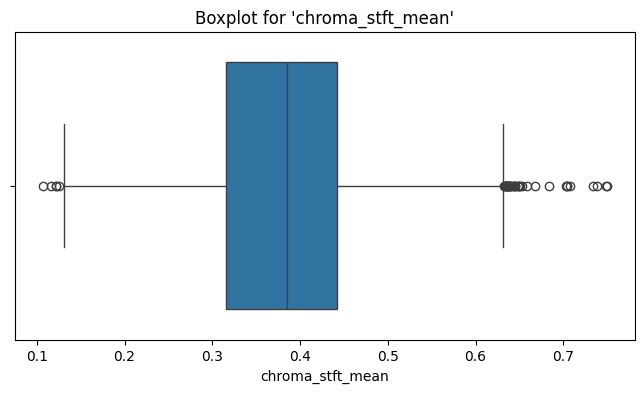

Detected 39 outlier(s) in 'chroma_stft_mean' using IQR method.


In [9]:
# Visualizing outliers for "chroma_stft_mean"
if 'chroma_stft_mean' in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data_df['chroma_stft_mean'])
    plt.title("Boxplot for 'chroma_stft_mean'")
    plt.xlabel("chroma_stft_mean")
    plt.show()
    
    # Detect outliers for "chroma_stft_mean"
    outliers_chroma = detect_outliers_iqr(data_df, 'chroma_stft_mean')
    print(f"Detected {len(outliers_chroma)} outlier(s) in 'chroma_stft_mean' using IQR method.")


In [10]:
 # Remove outliers from the 'chroma_stft_mean' column.
data_df_clean = remove_outliers_iqr(data_df, 'chroma_stft_mean')
print("New shape after removing outliers from 'chroma_stft_mean':", data_df_clean.shape)

New shape after removing outliers from 'chroma_stft_mean': (9951, 60)


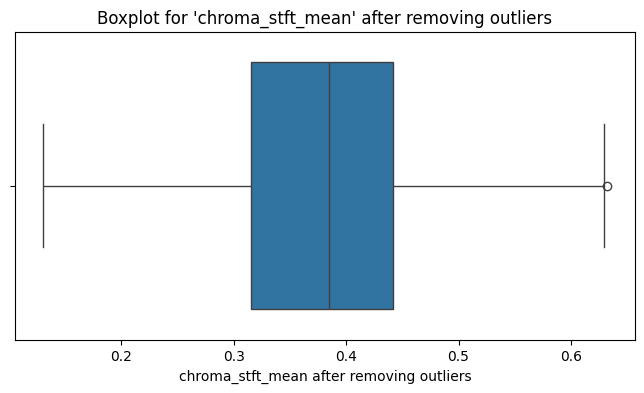

Detected 1 outlier(s) in 'chroma_stft_mean' using IQR method.


In [11]:
# Visualizing after removing outliers for "chroma_stft_mean"
if 'chroma_stft_mean' in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data_df_clean['chroma_stft_mean'])
    plt.title("Boxplot for 'chroma_stft_mean' after removing outliers")
    plt.xlabel("chroma_stft_mean after removing outliers")
    plt.show()
    
    outliers_chroma = detect_outliers_iqr(data_df_clean, 'chroma_stft_mean')
    print(f"Detected {len(outliers_chroma)} outlier(s) in 'chroma_stft_mean' using IQR method.")

### Step 3: Data Exploration

In [12]:
# Statistical summaries of the clean dataset after outlier removal
print("\nStatistical summary of the clean dataset:")
print(data_df_clean.describe())


Statistical summary of the clean dataset:
        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9951.0       9951.000000      9951.000000  9951.000000  9.951000e+03   
mean   66149.0          0.378697         0.085035     0.130743  2.683310e-03   
std        0.0          0.088895         0.009253     0.068147  3.589484e-03   
min    66149.0          0.130597         0.043849     0.001539  1.257168e-07   
25%    66149.0          0.315540         0.079916     0.083859  6.201435e-04   
50%    66149.0          0.384476         0.085150     0.121355  1.496230e-03   
75%    66149.0          0.441795         0.091120     0.176296  3.142374e-03   
max    66149.0          0.631682         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9951.000000           9.951000e+03              9951.000000   
mean              2195.408620           4.174557e+05              2240.748

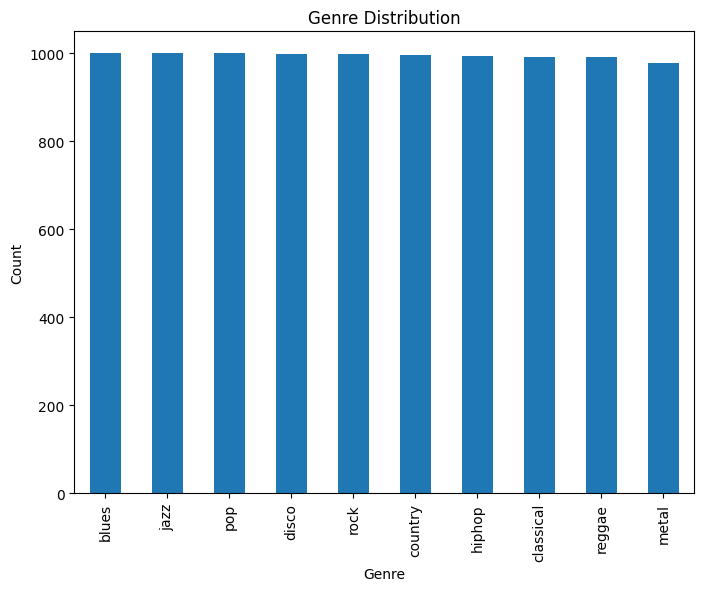

In [13]:
# Visualization: Distribution of genres
plt.figure(figsize=(8,6))
data_df_clean['label'].value_counts().plot(kind='bar')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

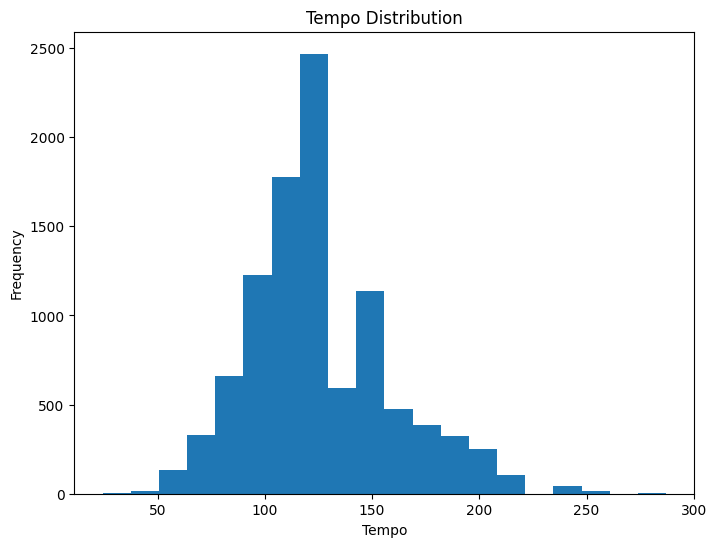

In [14]:
# Visualization: For any specific numeric feature (e.g., 'tempo')
if 'tempo' in data_df_clean.columns:
    plt.figure(figsize=(8,6))
    plt.hist(data_df_clean['tempo'], bins=20)
    plt.title("Tempo Distribution")
    plt.xlabel("Tempo")
    plt.ylabel("Frequency")
    plt.show()

**Loading some samples per genre from the dataset**

Rock   

Classical

### Step 4: Feature Engineering

In [15]:
# Dropping 'filename' column
columns_to_drop = []
if 'filename' in data_df_clean.columns:
    columns_to_drop.append('filename')

In [16]:
if columns_to_drop:
    data_df_clean = data_df.drop(columns=columns_to_drop)
    print(f"\nDropped columns: {columns_to_drop}")
    print("Data shape after dropping columns:", data_df_clean.shape)


Dropped columns: ['filename']
Data shape after dropping columns: (9990, 59)


In [17]:
# Feature extraction: 
labels = data_df_clean.iloc[:, -1] # The last column is the label
convertor = LabelEncoder()
y = convertor.fit_transform(labels)
y

array([0, 0, 0, ..., 9, 9, 9])

In [18]:
genres = list(convertor.classes_)
print(genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [19]:
# Printing the first 5 labels
print(data_df_clean.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [20]:
# Scaling features

scaler = StandardScaler()
x = scaler.fit_transform(np.array(data_df_clean.iloc[:, :-1], dtype = float))
print("\nFeature matrix shape:", x.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (9990, 58)
Labels shape: (9990,)


## Step 5. Model Selection

In [21]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print("\nTraining feature shape:", x_train.shape)
print("Testing feature shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)



Training feature shape: (6693, 58)
Testing feature shape: (3297, 58)
Training labels shape: (6693,)
Testing labels shape: (3297,)


### Logistic Regression

In [22]:
# Logistic Regression
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(x_train, y_train)
y_pred_logistic_reg = logistic_reg.predict(x_test)

#Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic_reg))
print(classification_report(y_test, y_pred_logistic_reg, target_names=genres))
log_reg_acc = accuracy_score(y_test, logistic_reg.predict(x_test))

Logistic Regression Accuracy: 0.7336973005762815
              precision    recall  f1-score   support

       blues       0.74      0.72      0.73       345
   classical       0.89      0.94      0.92       334
     country       0.64      0.65      0.64       313
       disco       0.66      0.65      0.66       335
      hiphop       0.74      0.70      0.72       340
        jazz       0.78      0.81      0.79       313
       metal       0.82      0.83      0.83       340
         pop       0.76      0.86      0.81       300
      reggae       0.71      0.67      0.69       341
        rock       0.57      0.53      0.55       336

    accuracy                           0.73      3297
   macro avg       0.73      0.74      0.73      3297
weighted avg       0.73      0.73      0.73      3297



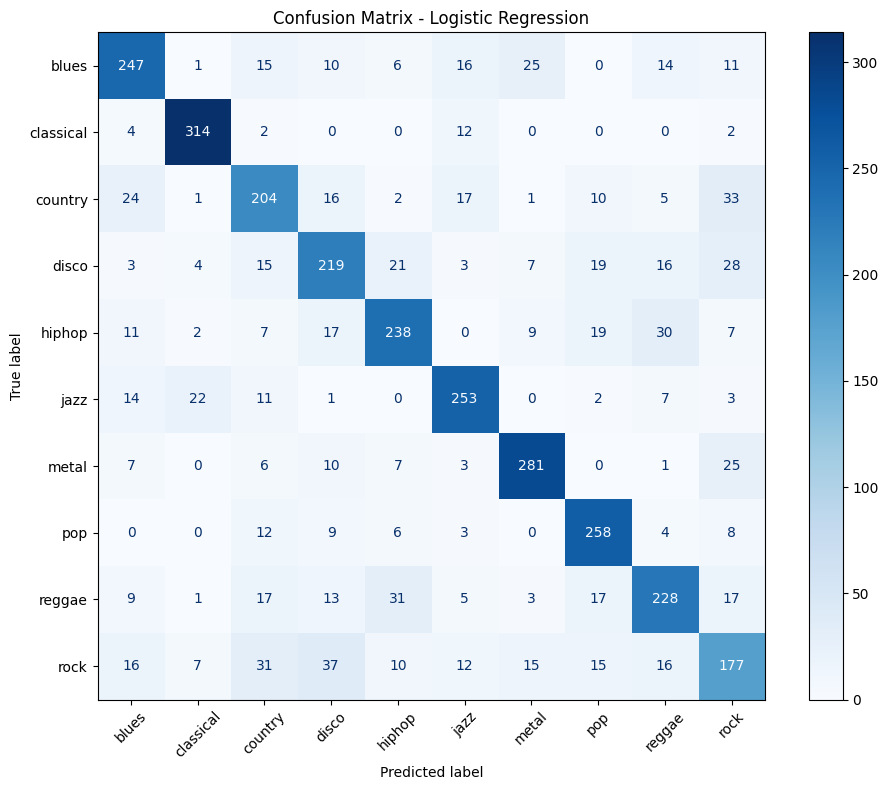

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logistic_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


### SVM (Support Vector Machine)

In [24]:
# SVM Model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)

#Evaluation
print("Support Vector Machine Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=genres))
svm_acc = accuracy_score(y_test, svm_model.predict(x_test))

Support Vector Machine Accuracy: 0.9144676979071884
              precision    recall  f1-score   support

       blues       0.91      0.95      0.93       345
   classical       0.91      0.97      0.94       334
     country       0.86      0.84      0.85       313
       disco       0.89      0.90      0.89       335
      hiphop       0.94      0.93      0.93       340
        jazz       0.92      0.92      0.92       313
       metal       0.95      0.96      0.95       340
         pop       0.93      0.94      0.93       300
      reggae       0.92      0.94      0.93       341
        rock       0.91      0.80      0.85       336

    accuracy                           0.91      3297
   macro avg       0.91      0.91      0.91      3297
weighted avg       0.91      0.91      0.91      3297



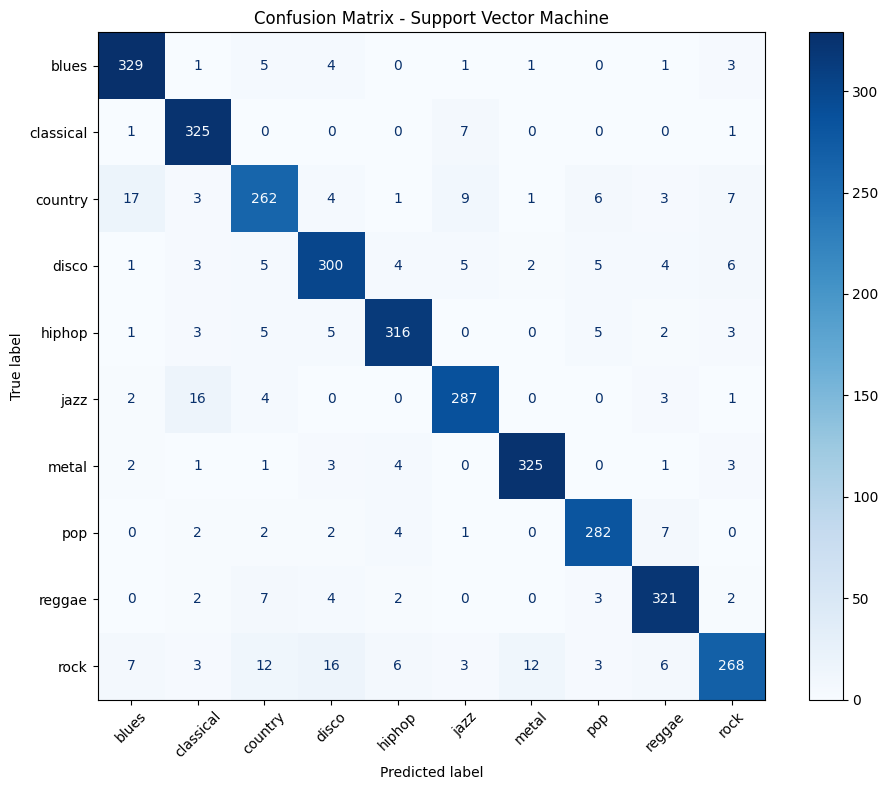

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Support Vector Machine")
plt.tight_layout()
plt.show()

### ANN (Simple Artificial Neural Network)

In [26]:
# ANN - Artificial Neural Network
model_ann = Sequential([
    Dense(128, input_shape=(x_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # softmax - multiclass
])

# Compile
model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model_ann.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

#Evaluation
loss, ann_acc = model_ann.evaluate(x_test, y_test)
print(f"ANN Accuracy: {ann_acc:.4f}")

# Predictions
y_pred_ann = model_ann.predict(x_test)
y_pred_labels = y_pred_ann.argmax(axis=1)


Epoch 1/50
168/168 [==============================] - 4s 8ms/step - loss: 1.7358 - accuracy: 0.3829 - val_loss: 1.2614 - val_accuracy: 0.5743
Epoch 2/50
168/168 [==============================] - 1s 5ms/step - loss: 1.2971 - accuracy: 0.5407 - val_loss: 1.0555 - val_accuracy: 0.6423
Epoch 3/50
168/168 [==============================] - 1s 6ms/step - loss: 1.1333 - accuracy: 0.6068 - val_loss: 0.9441 - val_accuracy: 0.6863
Epoch 4/50
168/168 [==============================] - 1s 4ms/step - loss: 1.0216 - accuracy: 0.6406 - val_loss: 0.8712 - val_accuracy: 0.7147
Epoch 5/50
168/168 [==============================] - 1s 3ms/step - loss: 0.9769 - accuracy: 0.6589 - val_loss: 0.8087 - val_accuracy: 0.7267
Epoch 6/50
168/168 [==============================] - 1s 3ms/step - loss: 0.9131 - accuracy: 0.6890 - val_loss: 0.7694 - val_accuracy: 0.7371
Epoch 7/50
168/168 [==============================] - 1s 3ms/step - loss: 0.8718 - accuracy: 0.6920 - val_loss: 0.7603 - val_accuracy: 0.7476
Epoch 

In [27]:
# Report
report_dict = classification_report(y_test, y_pred_labels, target_names=genres, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
summary_df = report_df.iloc[:-3]

print(f"Artificial Neural Network Accuracy: {ann_acc}")

# Print classification report
print(classification_report(y_test, y_pred_labels, target_names=genres))

Artificial Neural Network Accuracy: 0.8574461340904236
              precision    recall  f1-score   support

       blues       0.86      0.89      0.88       345
   classical       0.88      0.98      0.93       334
     country       0.84      0.78      0.81       313
       disco       0.78      0.83      0.81       335
      hiphop       0.89      0.84      0.86       340
        jazz       0.90      0.84      0.87       313
       metal       0.95      0.92      0.93       340
         pop       0.88      0.89      0.89       300
      reggae       0.82      0.86      0.84       341
        rock       0.79      0.73      0.76       336

    accuracy                           0.86      3297
   macro avg       0.86      0.86      0.86      3297
weighted avg       0.86      0.86      0.86      3297



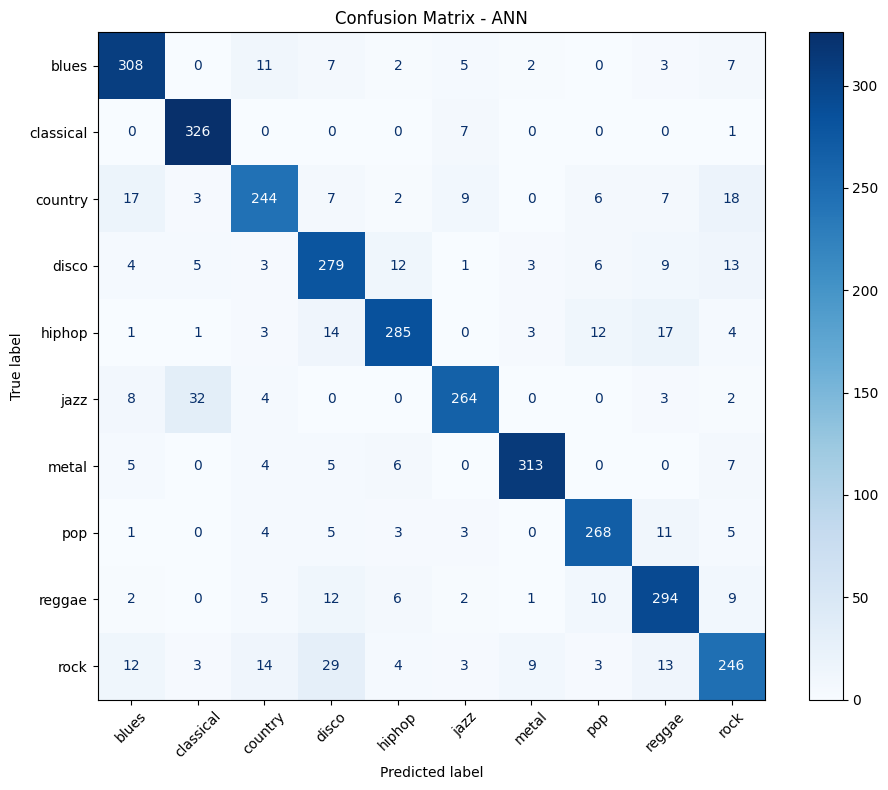

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - ANN")
plt.tight_layout()
plt.show()

### Decision tree Model 


 Classification Report (Training Set - Decision Tree):
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       655
   classical       1.00      1.00      1.00       664
     country       1.00      1.00      1.00       684
       disco       1.00      1.00      1.00       664
      hiphop       1.00      1.00      1.00       658
        jazz       1.00      1.00      1.00       687
       metal       0.99      1.00      1.00       660
         pop       1.00      1.00      1.00       700
      reggae       1.00      1.00      1.00       659
        rock       1.00      0.99      1.00       662

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693



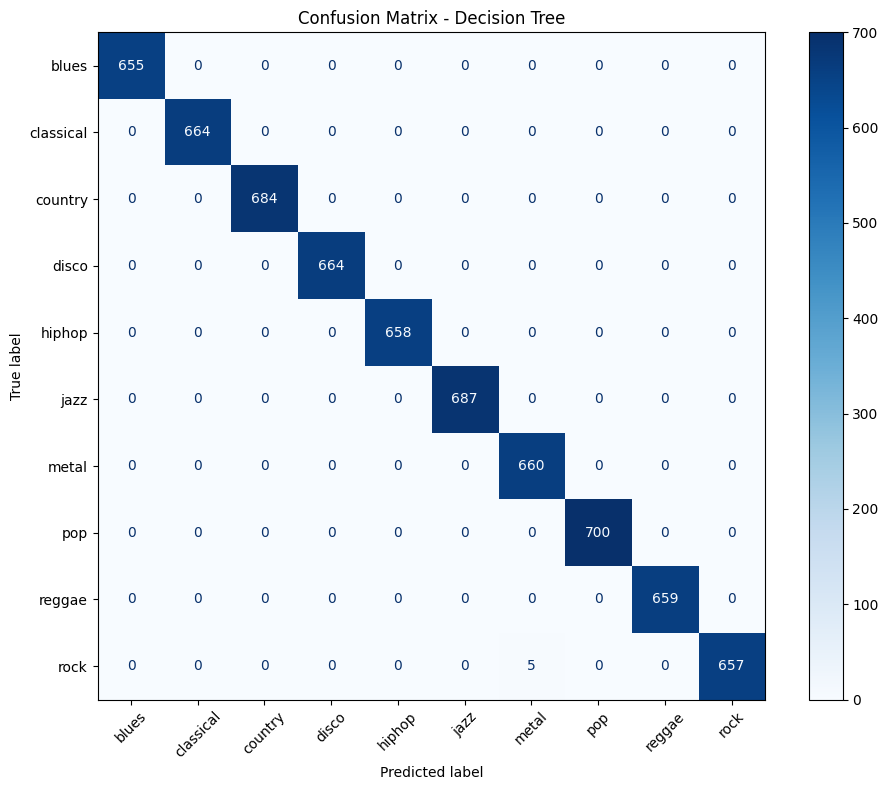


 Classification Report (Test Set - Decision Tree):
              precision    recall  f1-score   support

       blues       0.64      0.56      0.60       345
   classical       0.85      0.82      0.83       334
     country       0.48      0.49      0.49       313
       disco       0.58      0.56      0.57       335
      hiphop       0.65      0.68      0.66       340
        jazz       0.62      0.70      0.66       313
       metal       0.76      0.78      0.77       340
         pop       0.73      0.77      0.75       300
      reggae       0.61      0.60      0.60       341
        rock       0.50      0.49      0.49       336

    accuracy                           0.64      3297
   macro avg       0.64      0.64      0.64      3297
weighted avg       0.64      0.64      0.64      3297



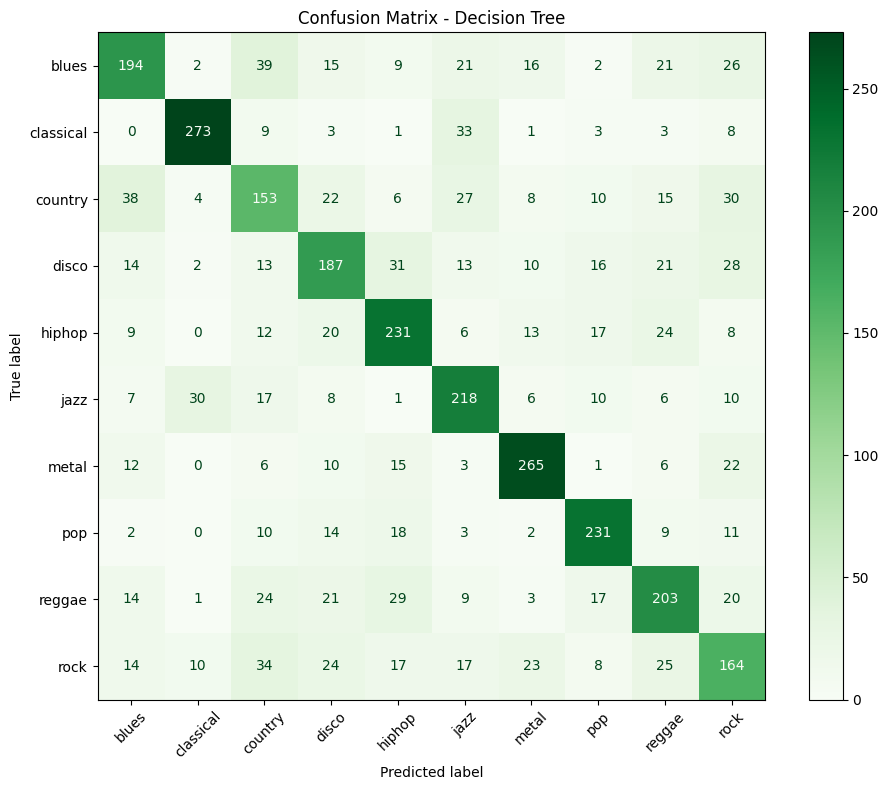

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Build pipeline with Decision Tree
pipe = Pipeline([
    ('model', DecisionTreeClassifier(random_state=42)) 
])

# Train the model
pipe.fit(x_train, y_train)

# Evaluation on TRAINING set
y_train_pred = pipe.predict(x_train)

print("\n Classification Report (Training Set - Decision Tree):")
print(classification_report(y_train, y_train_pred, target_names= genres))

cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()

# Evaluation on TEST set
y_test_pred = pipe.predict(x_test)

print("\n Classification Report (Test Set - Decision Tree):")
print(classification_report(y_test, y_test_pred, target_names=genres))

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()


### Radom Forest Model 


 Classification Report (Training Set):
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       655
   classical       1.00      1.00      1.00       664
     country       1.00      1.00      1.00       684
       disco       1.00      1.00      1.00       664
      hiphop       1.00      1.00      1.00       658
        jazz       1.00      1.00      1.00       687
       metal       0.99      1.00      1.00       660
         pop       1.00      1.00      1.00       700
      reggae       1.00      1.00      1.00       659
        rock       1.00      0.99      1.00       662

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693



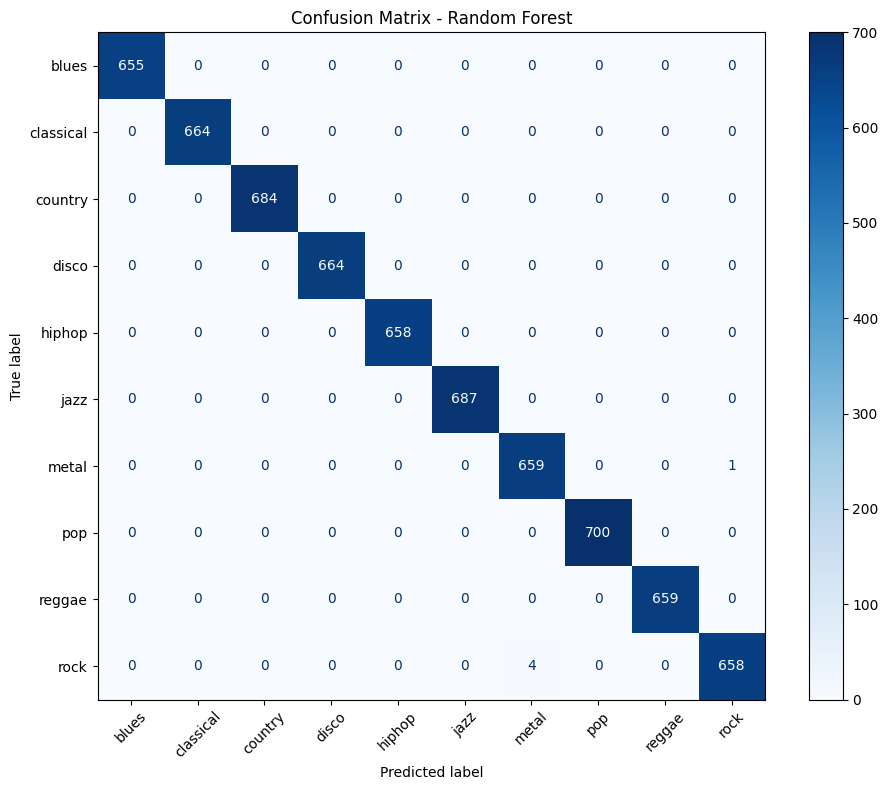


 Classification Report (Test Set):
              precision    recall  f1-score   support

       blues       0.88      0.82      0.85       345
   classical       0.90      0.96      0.93       334
     country       0.76      0.80      0.78       313
       disco       0.85      0.83      0.84       335
      hiphop       0.89      0.84      0.87       340
        jazz       0.79      0.89      0.84       313
       metal       0.90      0.95      0.92       340
         pop       0.86      0.91      0.89       300
      reggae       0.87      0.87      0.87       341
        rock       0.86      0.71      0.78       336

    accuracy                           0.86      3297
   macro avg       0.86      0.86      0.86      3297
weighted avg       0.86      0.86      0.86      3297



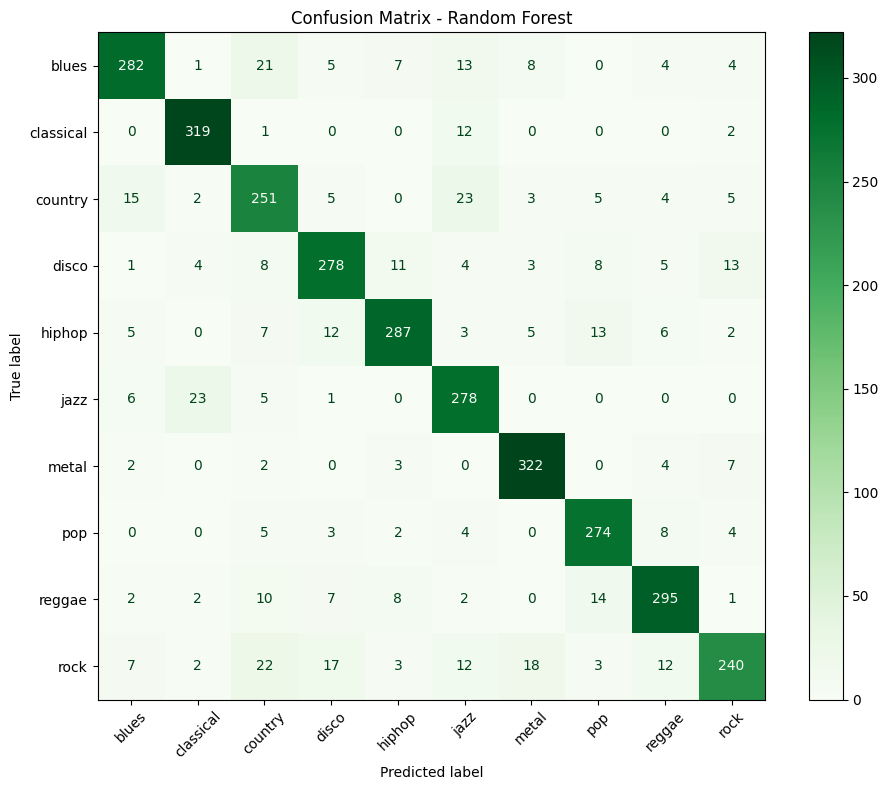

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Build pipeline
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Fit model
pipe.fit(x_train, y_train)

#  Evaluation on TRAINING set 
y_train_pred = pipe.predict(x_train)

print("\n Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred, target_names=genres))

cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

#  Evaluation on TEST set 
y_test_pred = pipe.predict(x_test)

print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=genres))

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


### RNN (Recurrent Neural Network)

 #### Prepare your dataset as sequences

In [44]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\oscar\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


In [45]:
import os
import librosa
import numpy as np

def extract_mfcc_sequence_from_segment(y_segment, sr, n_mfcc=20, max_len=130):
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=n_mfcc)

    # Pad or trim to fixed length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.T  # shape: (max_len, n_mfcc)

def build_segmented_dataset(base_dir, segment_duration=3, n_mfcc=20, max_len=130):
    X = []
    y = []

    for genre in os.listdir(base_dir):
        genre_path = os.path.join(base_dir, genre)
        if not os.path.isdir(genre_path): continue

        for file in os.listdir(genre_path):
            if not file.endswith(".wav"):
                continue

            file_path = os.path.join(genre_path, file)
            try:
                y_audio, sr = librosa.load(file_path, sr=None)
                y_audio, _ = librosa.effects.trim(y_audio)

                samples_per_segment = int(segment_duration * sr)
                num_segments = len(y_audio) // samples_per_segment

                for i in range(num_segments):
                    start = i * samples_per_segment
                    end = start + samples_per_segment
                    segment = y_audio[start:end]

                    if len(segment) == samples_per_segment:
                        mfcc_seq = extract_mfcc_sequence_from_segment(segment, sr, n_mfcc, max_len)
                        X.append(mfcc_seq)
                        y.append(genre)

            except Exception as e:
                print(f" Skipping {file_path}: {e}")

    return np.array(X), np.array(y)


In [46]:
base_dir = f"{path}\\Data\\genres_original"

X, y = build_segmented_dataset(base_dir)

print("X shape:", X.shape)  # Expected: (num_segments, 130, 20)
print("y shape:", y.shape)  # Expected: (num_segments,)

C:\Users\oscar\AppData\Local\Temp\ipykernel_10220\158984778.py:31: UserWarning: PySoundFile failed. Trying audioread instead.
  y_audio, sr = librosa.load(file_path, sr=None)
c:\Users\oscar\anaconda3\envs\py310\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Skipping C:\Users\oscar\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1\Data\genres_original\jazz\jazz.00054.wav: 
X shape: (9980, 130, 20)
y shape: (9980,)


In [47]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization

model = Sequential([
    Masking(mask_value=0., input_shape=(130, 20)),

    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),  # Optional here
    Dropout(0.3),

    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print('Training feature shape:',X_train.shape)
print("Testing feature shape:",X_test.shape)
print("Training labels shape:",y_train.shape)
print("Testing labels shape:",y_test.shape)

Training feature shape: (7984, 130, 20)
Testing feature shape: (1996, 130, 20)
Training labels shape: (7984, 10)
Testing labels shape: (1996, 10)


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
250/250 [==============================] - 20s 42ms/step - loss: 2.1335 - accuracy: 0.3072 - val_loss: 1.5228 - val_accuracy: 0.4594
Epoch 2/100
250/250 [==============================] - 8s 32ms/step - loss: 1.6306 - accuracy: 0.4296 - val_loss: 1.3414 - val_accuracy: 0.5266
Epoch 3/100
250/250 [==============================] - 8s 32ms/step - loss: 1.4529 - accuracy: 0.4889 - val_loss: 1.2097 - val_accuracy: 0.5641
Epoch 4/100
250/250 [==============================] - 10s 41ms/step - loss: 1.3172 - accuracy: 0.5412 - val_loss: 1.1729 - val_accuracy: 0.5917
Epoch 5/100
250/250 [==============================] - 9s 38ms/step - loss: 1.2609 - accuracy: 0.5648 - val_loss: 1.1020 - val_accuracy: 0.6132
Epoch 6/100
250/250 [==============================] - 8s 32ms/step - loss: 1.1543 - accuracy: 0.6075 - val_loss: 1.0338 - val_accuracy: 0.6468
Epoch 7/100
250/250 [==============================] - 8s 32ms/step - loss: 1.1567 - accuracy: 0.6120 - val_loss: 1.0583 - val_accurac

In [51]:
#Evaluate test performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}")

63/63 [==============================] - 1s 12ms/step - loss: 0.4644 - accuracy: 0.8878
 Final Test Accuracy: 0.8878
 Final Test Loss: 0.4644


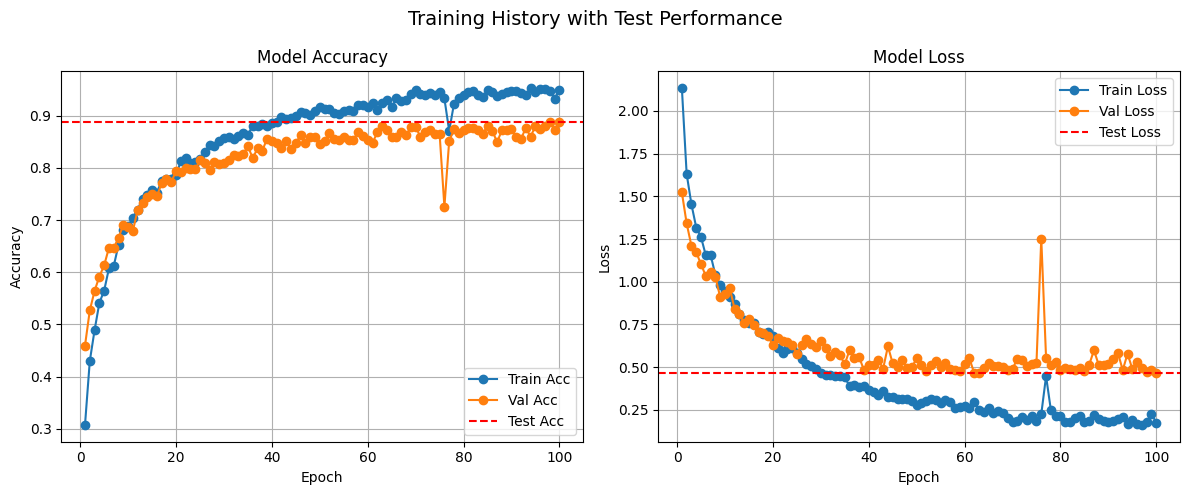

In [52]:

#Plot training history with test performance
def plot_training_history_with_test(history, test_loss=None, test_acc=None):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Acc', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Acc', marker='o')
    if test_acc is not None:
        plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Acc')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss', marker='o')
    if test_loss is not None:
        plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Training History with Test Performance", fontsize=14)
    plt.tight_layout()
    plt.show()

# 6. Call the plot function
plot_training_history_with_test(history, test_loss=test_loss, test_acc=test_acc)

### CNN (Convolutional Neural Network)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    model = Sequential()
    
    # 1st conv block
    model.add(Conv2D(32, (2, 2), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd conv block
    model.add(Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv block
    model.add(Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [54]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# CNN expects 4D input: (samples, height, width, channels)
X_cnn = X[..., np.newaxis]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_onehot, test_size=0.2, random_state=42)

# Build and train the model
input_shape = X_train.shape[1:]  # (timesteps, features, 1)
num_classes = y_onehot.shape[1]

model = build_model(input_shape, num_classes)

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))


Epoch 1/100
250/250 [==============================] - 6s 7ms/step - loss: 1.8299 - accuracy: 0.3725 - val_loss: 1.4146 - val_accuracy: 0.5110
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 1.4584 - accuracy: 0.4811 - val_loss: 1.1996 - val_accuracy: 0.5827
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 1.2192 - accuracy: 0.5716 - val_loss: 1.0253 - val_accuracy: 0.6273
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 1.0430 - accuracy: 0.6378 - val_loss: 0.9593 - val_accuracy: 0.6708
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.9091 - accuracy: 0.6895 - val_loss: 0.8454 - val_accuracy: 0.7004
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.7863 - accuracy: 0.7355 - val_loss: 0.8755 - val_accuracy: 0.7194
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 0.7186 - accuracy: 0.7543 - val_loss: 0.8578 - val_accuracy: 0.7094

In [55]:
# Evaluate test performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}")

63/63 [==============================] - 0s 3ms/step - loss: 1.9503 - accuracy: 0.7355
 Final Test Accuracy: 0.7355
 Final Test Loss: 1.9503


63/63 [==============================] - 0s 3ms/step - loss: 1.9503 - accuracy: 0.7355


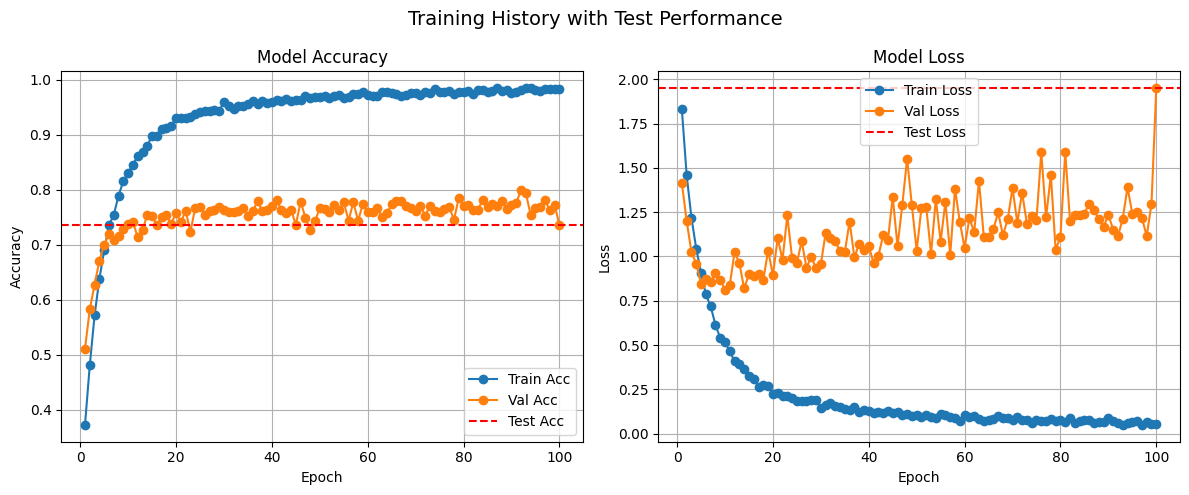

In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test)
plot_training_history_with_test(history, test_loss, test_acc)


### Step 6: Hyperparameter Tuning

In [57]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\oscar\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


### Step 7: Save Models (Pickle Files)

### Step 8: Web Application (Flask or Streamlit)